In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import cmocean
import matplotlib.pyplot as plt

import numpy as np
import xarray as xr

import warnings
import CM4Xutils
import sectionate as sec
import regionate as reg
import tosnap

import xbudget
import xwmb

In [12]:
atl = reg.open_grs("../data/Atlantic.grs", CM4Xutils.ds_to_grid)

Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`
Inferring Z grid coordinate: density `sigma2`


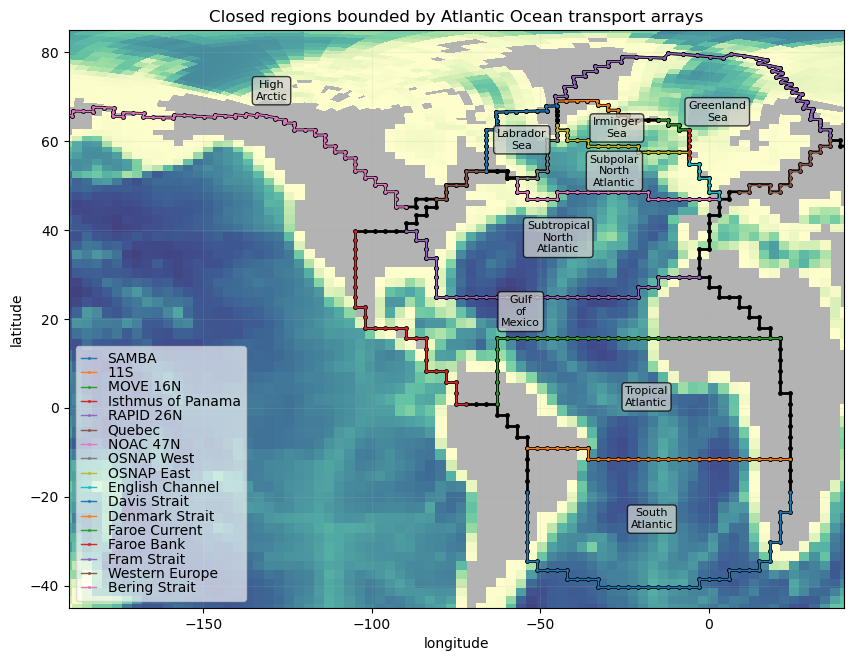

In [123]:
cmap = cmocean.cm.deep.copy()
cmap.set_bad((0.7, 0.7, 0.7))

plt.figure(figsize=(10, 7.5))

ax = plt.subplot(facecolor=(0.7, 0.7, 0.7))
plt.pcolor(
    atl.grid._ds['geolon_c'],
    atl.grid._ds['geolat_c'],
    atl.grid._ds['deptho'].where(atl.grid._ds['deptho']>0),
    cmap=cmap, vmin=0, vmax=7500,
)
plt.xlim(-190, 40)
plt.ylim(-45, 85)

for region_name, region in atl.region_dict.items():
    lons, lats = reg.loop(region.lons), reg.loop(region.lats)
    abs_diff = np.abs(np.diff(lons))
    if abs_diff.max() > 180.:
        periodic_idx = np.argmax(np.abs(np.diff(lons)))
        lons[periodic_idx-1:periodic_idx+1] = np.nan
    plt.plot(lons, lats, "k.-", markersize=5, linewidth=2.0)
    xy = (
        region.grid._ds.geolon.where(region.mask).mean(),
        region.grid._ds.geolat.where(region.mask).mean()
    )
    bbox = dict(boxstyle="round", fc="0.8", alpha=0.75)
    plt.annotate(region.name.replace(" ","\n"), xy=xy, color="k", ha="center", va="center", fontsize=8, bbox=bbox)

unique_labels = []
for region_name, region in atl.region_dict.items():
    for child_name, child in region.children.items():
        if child_name in unique_labels:
            continue
        else:
            unique_labels.append(child_name)
            lons, lats = child.lons.copy(), child.lats.copy()
            abs_diff = np.abs(np.diff(lons))
            if abs_diff.max() > 180.:
                periodic_idx = np.argmax(np.abs(np.diff(lons)))
                lons[periodic_idx-1:periodic_idx+1] = np.nan
            plt.plot(lons, lats, "s-", label=child_name, linewidth=1., markersize=1)
    
plt.legend(loc="lower left", handlelength=1.1, labelspacing=0.025, fontsize=10, framealpha=0.65)
plt.grid(True, alpha=0.15)
plt.xlabel("longitude")
plt.ylabel("latitude");
plt.title("Closed regions bounded by Atlantic Ocean transport arrays")
plt.savefig("../figures/Atlantic_mooring_array_regions.png", bbox_inches="tight", dpi=300)

In [66]:
spna = (atl.region_dict["Labrador_Sea"].save["wmt"] + atl.region_dict["Irminger_Sea"].save["wmt"]).sel(exp="control")
osnap = (
     (-atl.region_dict["Labrador_Sea"].children["OSNAP West"].save["wmt"]["convergent_mass_transport"])
    +(-atl.region_dict["Irminger_Sea"].children["OSNAP East"].save["wmt"]["convergent_mass_transport"])
).sel(exp="control")

sigma2_osnap_max = osnap.mean("time").idxmax("sigma2_l_target")
osnap_max = osnap.sel(sigma2_l_target=sigma2_osnap_max.values)
sfwmt_max = spna.boundary_fluxes.sel(sigma2_l_target=sigma2_osnap_max.values)

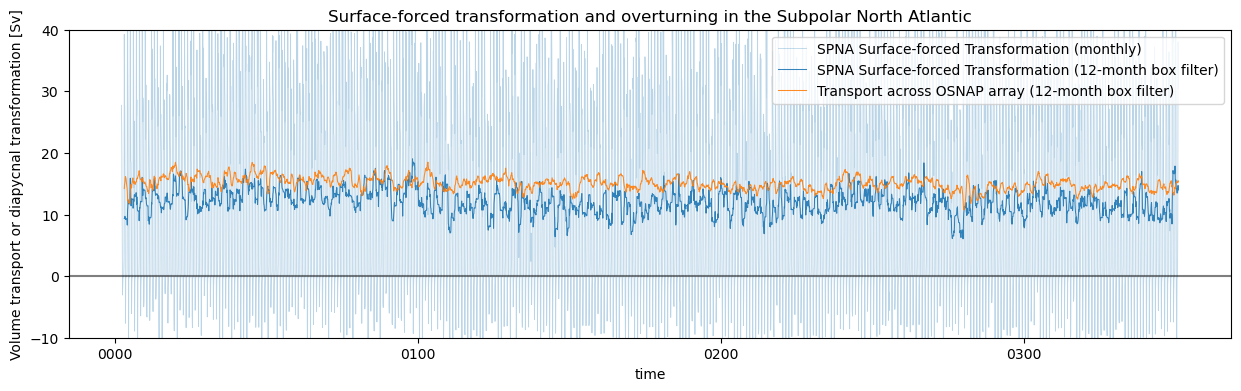

In [93]:
toSv = 1e-6/1035.
plt.figure(figsize=(15,4))
(sfwmt_max*toSv).plot(color="C0", lw=0.6, alpha=0.3, label="SPNA Surface-forced Transformation (monthly)")
(sfwmt_max*toSv).rolling({"time":12}).mean("time").plot(color="C0", lw=0.75, alpha=0.9, label="SPNA Surface-forced Transformation (12-month box filter)")

(osnap_max*toSv).rolling({"time":12}).mean("time").plot(color="C1", lw=0.75, alpha=0.9, label="Transport across OSNAP array (12-month box filter)")
plt.ylim(-10, 40)
plt.axhline(0., color="k", alpha=0.5)
plt.legend(loc="upper right")
plt.title("Surface-forced transformation and overturning in the Subpolar North Atlantic")
plt.ylabel("Volume transport or diapycnal transformation [Sv]");
plt.savefig("../figures/transformation_overturning_timeseries.png")